Что сделать?
+ импортировать(!!!), установив свой пакет мутспек в био-енв, класс для парсинга кодонов
+ залить туда функцию парсинга генбанка
+ заменить глупые is_syn & is_ff на стандартный лейбл, там лежит функция ~ get_mut_type
+ получить частоты тринуклеотидов и нуклеотидов простым подсчетом из Ref таблицы
+ воспользоваться уже написанной функцией подсчета мутспека. Ее нужно подправить - добавить вариант когда нужно считать дискретные состояния, а не вероятности, еще один аргумент
+ развернуть мутспек потому что он опять посчитан на L цепи, а надо перевести в H

- Поделить на H & L
- Разложить на подписи

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import re
import json
from collections import defaultdict
from functools import reduce, partial
from typing import List, Set, Tuple, Union
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Data import CodonTable
from Bio.Data.CodonTable import NCBICodonTableDNA
from Bio import SeqIO
from scipy import spatial

from mutspec_utils.annotation import (
    calculate_mutspec, CodonAnnotation, mutations_summary, 
    translator, rev_comp, lbl2lbl_id, lbl_id2lbl
)
from mutspec_utils.constants import possible_codons, possible_sbs12, possible_sbs192
from mutspec_utils.io import read_genbank_ref
from mutspec_utils.draw import plot_mutspec12, plot_mutspec192, plot_mutspec192kk

sns.set_style()

## Observed mutations

In [2]:
mutations = pd.read_csv("../data/processed/mutations.csv")
print(mutations.shape)
mutations.head()

(7611, 16)


,tissue,TurnOverDays,tumor_var_freq,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS,AltCodon,Label,Mut
0,Bladder,200.0,38.7900,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,NaN,0,T[T>C]G
1,Pancreas,360.0,21.0500,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,NaN,0,T[T>C]G
2,Bladder,200.0,10.1400,6011,T,TTA,1,CDS,COX1,108,3,CTT,426.0,CTC,2,T[T>C]A
3,Bladder,200.0,37.3900,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C
4,Esophagus,11.0,0.7013,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C


In [3]:
mutations.tissue.value_counts()

Liver              1273
Pancreas            861
Kidney              822
Prostate            739
Breast              689
Esophagus           409
Ovary               402
Lymphoid            316
Lung                268
CNS                 262
Colon/Rectum        224
Skin                217
Stomach             210
Thyroid             168
Bone/SoftTissue     155
Head/Neck           146
Uterus              145
Bladder              99
Biliary              90
Myeloid              78
Cervix               38
Name: tissue, dtype: int64

In [4]:
# drop some mutations
mutations = mutations[~mutations.tissue.isin(["CNS", "Lung", "Colon/Rectum", "Ovary"])]
mutations.shape

(6455, 16)

## Expected mutations

In [16]:
with open("../data/processed/expected_sbs192.json") as handle:
    exp_muts192 = json.load(handle)
with open("../data/processed/expected_sbs12.json") as handle:
    exp_muts12 = json.load(handle)

In [4]:
pd.DataFrame(exp_muts12).sort_index()

,ff,syn,all,allCYTB,D-loop,rRNA,tRNA,ExDloop
A>C,766,766,3148,325,339,861,527,4785
A>G,766,1308,3148,325,339,861,527,4785
A>T,766,766,3148,325,339,861,527,4785
C>A,817,817,3579,390,371,650,353,4810
C>G,817,817,3579,390,371,650,353,4810
C>T,817,1872,3579,390,371,650,353,4810
G>A,96,178,1294,137,150,451,217,2015
G>C,96,96,1294,137,150,451,217,2015
G>T,96,96,1294,137,150,451,217,2015
T>A,261,261,2758,286,260,548,405,3834


In [5]:
pd.DataFrame(exp_muts192).sort_index()

,ff,syn,all,allCYTB,D-loop,rRNA,tRNA,ExDloop
A[A>C]A,NaN,NaN,265,25.0,30,113,78.0,494
A[A>C]C,NaN,NaN,304,27.0,32,84,51.0,463
A[A>C]G,NaN,NaN,81,6.0,13,69,40.0,196
A[A>C]T,NaN,NaN,233,32.0,21,50,41.0,355
A[A>G]A,NaN,78.0,265,25.0,30,113,78.0,494
...,...,...,...,...,...,...,...,...
T[T>C]T,13.0,47.0,153,11.0,20,32,44.0,231
T[T>G]A,34.0,34.0,192,19.0,18,56,52.0,311
T[T>G]C,28.0,28.0,232,28.0,15,26,27.0,293
T[T>G]G,11.0,11.0,65,10.0,12,22,14.0,104


## Calculate mutspec

In [5]:
MutCDS = mutations[(mutations.Type == "CDS") & (mutations.Strand == 1)]
mutspec192 = pd.DataFrame({"Mut": possible_sbs192})
mutspec12 = pd.DataFrame({"Mut": possible_sbs12})

for lbl in exp_muts192:
    if lbl in {"all", "syn", "ff"}:
        ms192 = calculate_mutspec(MutCDS[MutCDS.Label >= lbl2lbl_id(lbl)], exp_muts192[lbl], use_context=True, use_proba=False)
        ms12 = calculate_mutspec(MutCDS[MutCDS.Label >= lbl2lbl_id(lbl)], exp_muts12[lbl],  use_context=False, use_proba=False)

    elif lbl == "allCYTB":
        MutCYTBall = MutCDS[(MutCDS.GeneName == "CYTB")]
        ms192 = calculate_mutspec(MutCYTBall, exp_muts192[lbl], use_context=True, use_proba=False)
        ms12 = calculate_mutspec(MutCYTBall, exp_muts12[lbl],  use_context=False, use_proba=False)

    elif lbl == "ExDloop":
        _MutExDloop = mutations[(mutations.Type != "D-loop")]  # & (mutations.Label >= 0) & (mutations.Strand == 1)
        ms192 = calculate_mutspec(_MutExDloop, exp_muts192[lbl], use_context=True, use_proba=False)
        ms12 = calculate_mutspec(_MutExDloop, exp_muts12[lbl],  use_context=False, use_proba=False)

    else:
        MutCustom = mutations[(mutations.Type == lbl)]
        ms192 = calculate_mutspec(MutCustom, exp_muts192[lbl], use_context=True, use_proba=False)
        ms12 = calculate_mutspec(MutCustom, exp_muts12[lbl],  use_context=False, use_proba=False)

    ms192.rename({"MutSpec": f"MutSpec_{lbl}"}, axis=1, inplace=True)
    ms12.rename({"MutSpec": f"MutSpec_{lbl}"}, axis=1, inplace=True)
    mutspec192 = pd.merge(mutspec192, ms192[["Mut", f"MutSpec_{lbl}"]], on="Mut")
    mutspec12 = pd.merge(mutspec12, ms12[["Mut", f"MutSpec_{lbl}"]], on="Mut")

# Reverse complement of Mut (to heavy strand)
mutspec192["Mut"] = mutspec192.Mut.apply(rev_comp)
mutspec12["Mut"] = mutspec12.Mut.str.translate(translator)
mutspec192.sort_values("Mut", inplace=True)
mutspec12.sort_values("Mut", inplace=True)

NameError: name 'exp_muts192' is not defined

In [7]:
mutspec192.to_csv("../data/processed/cancer_mutspec192.csv", index=None)
mutspec12.to_csv("../data/processed/cancer_mutspec12.csv",  index=None)

mutspec12[["Mut", "MutSpec_all", "MutSpec_syn", "MutSpec_ExDloop"]].to_csv("../data/processed/cancer_mutspec12custom.csv", index=None)
mutspec192[["Mut", "MutSpec_all", "MutSpec_syn", "MutSpec_ExDloop"]].to_csv("../data/processed/cancer_mutspec192custom.csv", index=None)

mutspec192.head()

,Mut,MutSpec_ff,MutSpec_syn,MutSpec_all,MutSpec_allCYTB,MutSpec_D-loop,MutSpec_rRNA,MutSpec_tRNA,MutSpec_ExDloop
191,A[A>C]A,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
187,A[A>C]C,0.000000,0.00000,0.001163,0.000000,0.000000,0.000681,0.000000,0.000741
183,A[A>C]G,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
179,A[A>C]T,0.000000,0.00000,0.000118,0.000000,0.000000,0.000000,0.000000,0.000080
175,A[A>G]A,0.012382,0.00619,0.008917,0.008524,0.004811,0.008852,0.006236,0.007838


In [8]:
mutspec12.head()

,Mut,MutSpec_ff,MutSpec_syn,MutSpec_all,MutSpec_allCYTB,MutSpec_D-loop,MutSpec_rRNA,MutSpec_tRNA,MutSpec_ExDloop
11,A>C,0.005298,0.005621,0.001716,0.001084,0.008854,0.003457,0.000000,0.001865
10,A>G,0.197790,0.191539,0.213878,0.190841,0.232171,0.191503,0.178052,0.195200
9,A>T,0.001766,0.001874,0.001560,0.000000,0.005903,0.004148,0.006805,0.002383
8,C>A,0.000000,0.000000,0.005652,0.009054,0.028989,0.004200,0.006350,0.006308
7,C>G,0.019205,0.020377,0.022610,0.015845,0.011936,0.026881,0.014816,0.022080


### Plot MutSpec

In [9]:
mutspec12 = pd.read_csv("../data/processed/cancer_mutspec12.csv")
mutspec192 = pd.read_csv("../data/processed/cancer_mutspec192.csv")

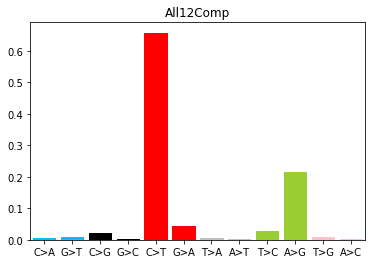

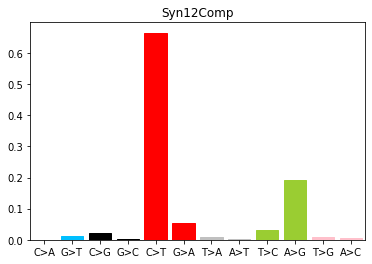

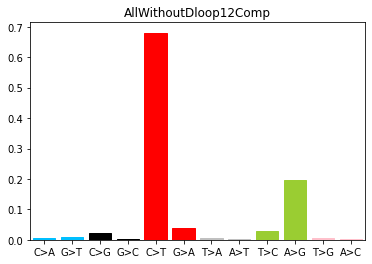

In [11]:
for mylbl, kplbl in [("MutSpec_all", "All12Comp"), ("MutSpec_syn", "Syn12Comp"), ("MutSpec_ExDloop", "AllWithoutDloop12Comp")]:
    plot_mutspec12(mutspec12, mylbl, kplbl, savepath=f"../figures/{kplbl}.pdf")

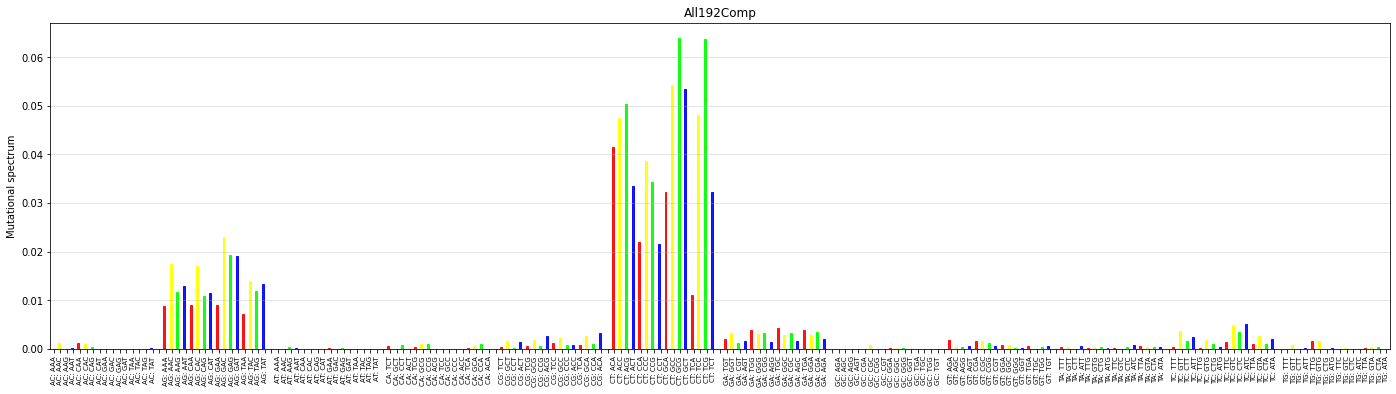

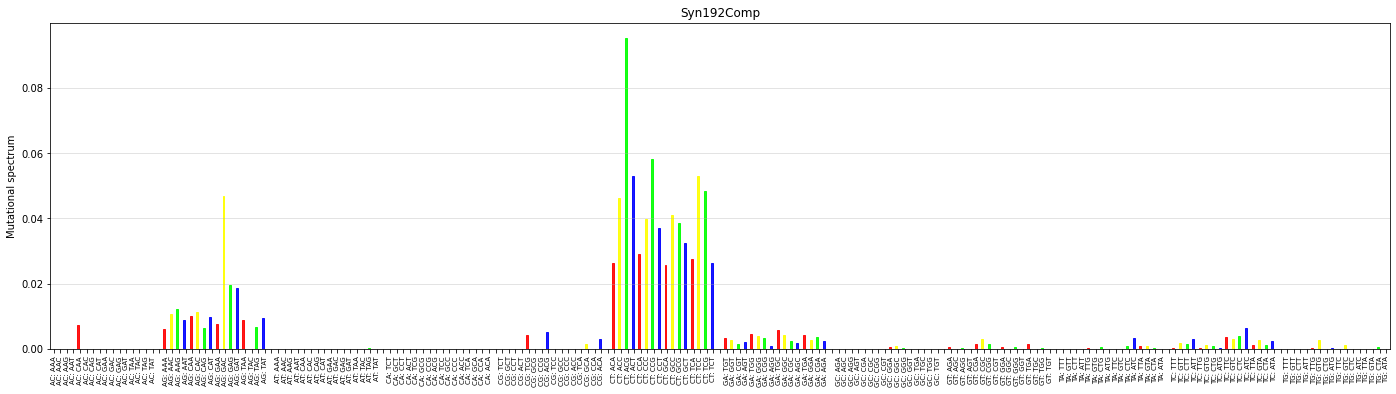

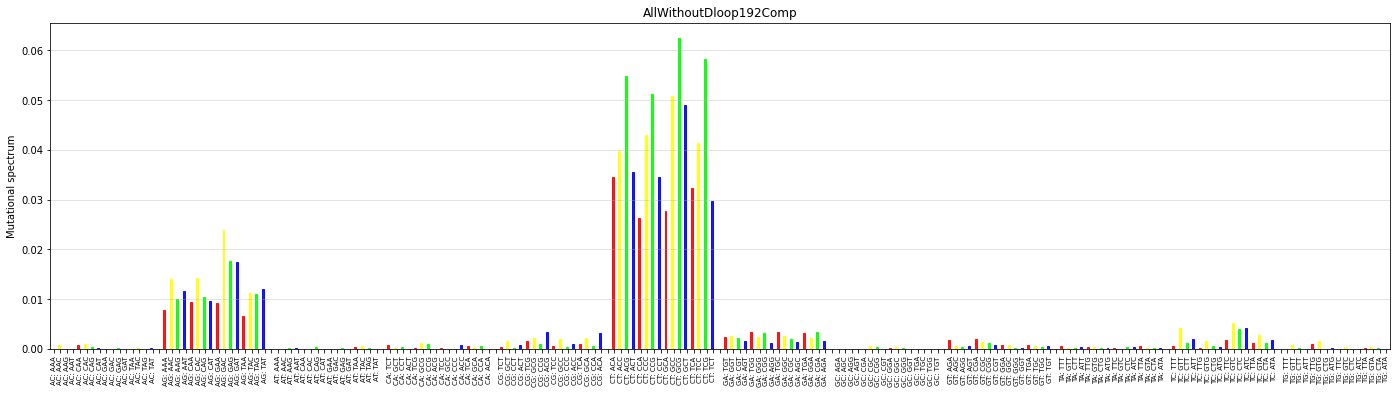

In [12]:
for mylbl, kplbl in [("MutSpec_all", "All192Comp"), ("MutSpec_syn", "Syn192Comp"), ("MutSpec_ExDloop", "AllWithoutDloop192Comp")]:
    plot_mutspec192kk(mutspec192, mylbl, kplbl, filepath=f"../figures/{kplbl}.pdf")

### Count similarities
Without missing data

In [6]:
coda = CodonAnnotation(2)

In [18]:
print("Excluding zeros (missing observations)\n")
print("Labels  \t\tCos_sim192\tEucDist192")
print("-" * 50)
_lbls = set()
for lbl1 in exp_muts192:
    if lbl1 == "ff":
        continue
    _lbls.add(lbl1)
    for lbl2 in exp_muts192:
        if lbl2 == "ff":
            continue
        if lbl1 != lbl2 and lbl2 not in _lbls:
            if lbl1 == "ff" or lbl2 == "ff":
                obs_muts = mutspec192.Mut.apply(lambda m: m[0] + m[2] + m[-1]).isin(coda.possible_ff_contexts)
            else:
                obs_muts = mutspec192.Mut.str.len() > 0  # all True

            dst192 = spatial.distance.cosine(
                mutspec192[f"MutSpec_{lbl1}"][obs_muts], mutspec192[f"MutSpec_{lbl2}"][obs_muts]
            )
            sim192 = 1 - dst192
            euc192 = spatial.distance.euclidean(
                mutspec192[f"MutSpec_{lbl1}"][obs_muts], mutspec192[f"MutSpec_{lbl2}"][obs_muts]
            )
            _lbl1 = "allCDS" if lbl1 == "all" else lbl1
            _both_labels = f"{_lbl1} & {lbl2}"
            _both_labels += " " * (22 - len(_both_labels))
            print(f"{_both_labels}\t{sim192:.3f}\t\t{euc192:.3f}")

Excluding zeros (missing observations)

Labels  		Cos_sim192	EucDist192
--------------------------------------------------
syn & all             	0.896		0.088
syn & allCYTB         	0.722		0.154
syn & D-loop          	0.527		0.176
syn & rRNA            	0.939		0.068
syn & tRNA            	0.855		0.105
syn & ExDloop         	0.930		0.073
allCDS & allCYTB      	0.841		0.116
allCDS & D-loop       	0.605		0.152
allCDS & rRNA         	0.947		0.061
allCDS & tRNA         	0.939		0.066
allCDS & ExDloop      	0.980		0.037
allCYTB & D-loop      	0.588		0.175
allCYTB & rRNA        	0.833		0.119
allCYTB & tRNA        	0.772		0.138
allCYTB & ExDloop     	0.848		0.113
D-loop & rRNA         	0.589		0.160
D-loop & tRNA         	0.584		0.162
D-loop & ExDloop      	0.609		0.151
rRNA & tRNA           	0.888		0.090
rRNA & ExDloop        	0.978		0.040
tRNA & ExDloop        	0.950		0.060


## Calculate similarities using hypoxia features

### Explorary features analysis

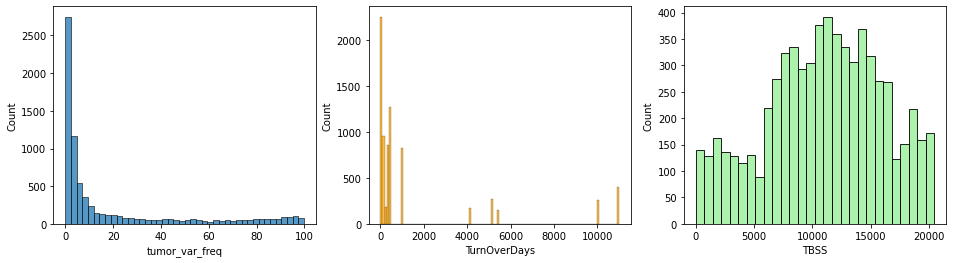

In [38]:
plt.figure(figsize=(16, 4))
plt.subplot(131)
sns.histplot(mutations["tumor_var_freq"])
plt.subplot(132)
sns.histplot(mutations["TurnOverDays"], color="orange")
plt.subplot(133)
sns.histplot(mutations["TBSS"], color="lightgreen")
plt.show()

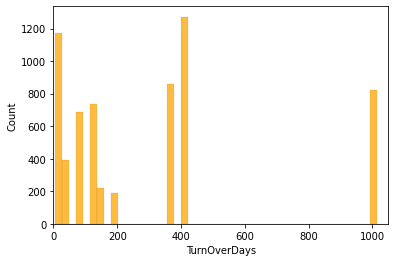

In [70]:
sns.histplot(mutations["TurnOverDays"], color="orange", bins=500, cumulative=False)
plt.xlim(0, 1050);

In [90]:
pd.DataFrame(mutations["TurnOverDays"].value_counts().sort_index()).T

,4.0,5.0,5.5,6.0,11.0,16.0,30.0,84.5,120.0,147.0,200.0,360.0,400.0,1000.0,4138.0,5143.0,5373.0,10000.0,11000.0
TurnOverDays,145,224,210,38,409,146,394,689,739,217,189,861,1273,822,168,268,155,262,402


### Add Dummy variables for hypoxia features

In [7]:
# # Looking at disributions
# mutations["DummyVAF"] = 0
# mutations.loc[(mutations.tumor_var_freq >= 5) & (mutations.tumor_var_freq < 10), "DummyVAF"] = 1
# mutations.loc[(mutations.tumor_var_freq >= 10) & (mutations.tumor_var_freq < 20), "DummyVAF"] = 2
# mutations.loc[(mutations.tumor_var_freq >= 20) & (mutations.tumor_var_freq < 50), "DummyVAF"] = 3
# mutations.loc[(mutations.tumor_var_freq >= 50) & (mutations.tumor_var_freq < 70), "DummyVAF"] = 4
# mutations.loc[(mutations.tumor_var_freq >= 70) & (mutations.tumor_var_freq < 80), "DummyVAF"] = 5
# mutations.loc[(mutations.tumor_var_freq >= 80) & (mutations.tumor_var_freq < 90), "DummyVAF"] = 6
# mutations.loc[mutations.tumor_var_freq >= 90, "DummyVAF"] = 7

# tbss_quart = mutations.TBSS.max() // 4
# print(tbss_quart)
# mutations["DummyTBSS"] = 0
# mutations.loc[(mutations.TBSS >= tbss_quart) & (mutations.TBSS < tbss_quart * 2), "DummyTBSS"] = 1
# mutations.loc[(mutations.TBSS >= tbss_quart  * 2) & (mutations.TBSS < tbss_quart * 3), "DummyTBSS"] = 2
# mutations.loc[mutations.TBSS >= tbss_quart * 3, "DummyTBSS"] = 3

# # ???
mutations["DummyTurnOver"] = 1                                                                        # Tiny
mutations.loc[(mutations.TurnOverDays >= 35) & (mutations.TurnOverDays < 250), "DummyTurnOver"] = 2   # Small
mutations.loc[(mutations.TurnOverDays > 250) & (mutations.TurnOverDays < 500), "DummyTurnOver"] = 3   # Medium
mutations.loc[mutations.TurnOverDays >= 1000, "DummyTurnOver"] = 4                                    # Large
# mutations.loc[(mutations.TurnOverDays > 4000) & (mutations.TurnOverDays < 6000), "DummyTurnOver"] = 5 # Huge
# mutations.loc[mutations.TurnOverDays > 8000, "DummyTurnOver"] = 6                                     # Eternal

In [8]:
mutations["DummyVAF"] = 0
mutations["DummyTBSS"] = 0
prev_qval_vaf = prev_qval_tbss = 0
n = 10
for i in range(1, n + 1):
    q = i / n
    qval_vaf = mutations.tumor_var_freq.max() + 1 if q == 1 else mutations.tumor_var_freq.quantile(q)
    mutations.loc[(mutations.tumor_var_freq >= prev_qval_vaf) & (mutations.tumor_var_freq < qval_vaf), "DummyVAF"] = i
    prev_qval_vaf = qval_vaf

    qval_tbss = mutations.TBSS.max() + 1 if q == 1 else mutations.TBSS.quantile(q)
    mutations.loc[(mutations.TBSS >= prev_qval_tbss) & (mutations.TBSS < qval_tbss), "DummyTBSS"] = i
    prev_qval_tbss = qval_tbss

In [21]:
mutations.TBSS.quantile(np.linspace(0.1, 1, 10))

0.1     3404.0
0.2     6755.4
0.3     8258.0
0.4     9793.0
0.5    11187.0
0.6    12526.0
0.7    13970.6
0.8    15454.0
0.9    17846.4
1.0    20450.0
Name: TBSS, dtype: float64

In [22]:
mutations.tumor_var_freq.quantile(np.linspace(0.1, 1, 10))

0.1     1.160
0.2     1.470
0.3     1.910
0.4     2.670
0.5     4.160
0.6     7.262
0.7    14.972
0.8    36.866
0.9    72.662
1.0    99.860
Name: tumor_var_freq, dtype: float64

In [25]:
# mutations.drop([x for x in mutations.columns if x.startswith("Dummy")], axis=1, inplace=True)
mutations.DummyTurnOver.value_counts(), mutations.DummyVAF.value_counts(), mutations.DummyTBSS.value_counts()

(3    2134
 2    1834
 1    1342
 4    1145
 Name: DummyTurnOver, dtype: int64,
 2     659
 5     649
 4     648
 8     646
 6     646
 10    646
 9     645
 7     645
 3     641
 1     630
 Name: DummyVAF, dtype: int64,
 0     872
 5     565
 1     559
 10    559
 7     559
 9     559
 2     558
 6     558
 3     557
 8     557
 4     552
 Name: DummyTBSS, dtype: int64)

### Cossim

In [26]:
mutations[mutations.Strand == -1].Type.value_counts()

D-loop    841
tRNA      172
CDS       143
Name: Type, dtype: int64

In [9]:
# TODO drop label==0
MutExDloop = mutations[(mutations.Type != "D-loop") & (mutations.Label >= 0)]  # & (mutations.Strand == 1)  TODO add stop_loss...
print(mutations.shape)
print(MutExDloop.shape)

(6455, 19)
(5369, 19)


In [10]:
def cossimExDloop(mut1: pd.DataFrame, mut2: pd.DataFrame, sbs=None):
    """
    Calculated MutSpec is on lignt strand => we must reverse sbs
    sbs is heavy chain mutation
    """
    ms1 = calculate_mutspec(mut1, exp_muts192["ExDloop"], use_context=True, use_proba=False)
    ms2 = calculate_mutspec(mut2, exp_muts192["ExDloop"], use_context=True, use_proba=False)
    if isinstance(sbs, str):
        assert bool(re.fullmatch("[ACGT]>[ACGT]", sbs))
        sbs = sbs.translate(translator)
        ms1 = ms1[ms1.Mut.str.contains(sbs)]
        ms2 = ms2[ms2.Mut.str.contains(sbs)]

    sim = 1 - spatial.distance.cosine(
        ms1.sort_values("Mut")["MutSpec"].values, 
        ms2.sort_values("Mut")["MutSpec"].values,
    )
    return sim


def sample_mutations(mutations: pd.DataFrame, method="bootstrap"):
    """bootstrap or permutations"""
    if method == "bootstrap":
        mutations = mutations.sample(mutations.shape[0], replace=True)
    elif method == "permutations":
        raise NotImplementedError()
    else:
        raise ValueError("Pass appropriate method: 'bootstrap' or 'permutations'")
    return mutations
    

def iterate_over_2_muts(mut1, mut2, niters, sbs=None):
    for _ in range(niters):
        mut1sample = sample_mutations(mut1, method="bootstrap")
        mut2sample = sample_mutations(mut2, method="bootstrap")
        yield mut1sample, mut2sample


def _calc_ms_cossim(x, sbs):
    return cossimExDloop(x[0], x[1], sbs)


def cossimExDloopSign(mut1, mut2, sbs=None, niters=1000, ci=95, threads=4):
    """
    Calculate cosine similarity using bootstrap sampling strategy
    """
    if niters == 1:
        sim = cossimExDloop(mut1, mut2, sbs)
        return sim, [sim, sim]
    if niters > 20:
        with Pool(threads) as p:
            expected_cossims = p.map(partial(_calc_ms_cossim, sbs=sbs), iterate_over_2_muts(mut1, mut2, niters))
    else:
        expected_cossims = [cossimExDloop(x1, x2, sbs) for x1, x2 in iterate_over_2_muts(mut1, mut2, niters)]

    cossim_mean = np.mean(expected_cossims)
    confint = np.percentile(expected_cossims, [(100 - ci) / 2, 100 - (100 - ci) / 2])
    return cossim_mean, list(confint)

In [31]:
# Low TurnOver VS High TurnOver

mut1 = MutExDloop[(MutExDloop.DummyTurnOver == 1)]
mut2 = MutExDloop[(MutExDloop.DummyTurnOver == 4)]
print(f"mut1 count = {mut1.shape[0]}\nmut2 count = {mut2.shape[0]}\ncossim = {cossimExDloop(mut1, mut2):.3f}\n")

mut1 = MutExDloop[(MutExDloop.DummyTurnOver == 1)]
mut2 = MutExDloop[(MutExDloop.DummyTurnOver > 1)]
print(f"mut1 count = {mut1.shape[0]}\nmut2 count = {mut2.shape[0]}\ncossim = {cossimExDloop(mut1, mut2):.3f}\n")

mut1 count = 1134
mut2 count = 916
cossim = 0.962

mut1 count = 1134
mut2 count = 4235
cossim = 0.977



In [32]:
# Low TurnOver VS High TurnOver

mut1 = MutExDloop[(MutExDloop.DummyTurnOver == 1)]
mut2 = MutExDloop[(MutExDloop.DummyTurnOver == 4)]
cs, confint = cossimExDloopSign(mut1, mut2)
print(f"mut1 count = {mut1.shape[0]}\nmut2 count = {mut2.shape[0]}\ncossim = {cs:.3f}\nconfint = {confint}\n")

mut1 = MutExDloop[(MutExDloop.DummyTurnOver == 1)]
mut2 = MutExDloop[(MutExDloop.DummyTurnOver > 1)]
cs, confint = cossimExDloopSign(mut1, mut2)
print(f"mut1 count = {mut1.shape[0]}\nmut2 count = {mut2.shape[0]}\ncossim = {cs:.3f}\nconfint = {confint}")

mut1 count = 1134
mut2 count = 916
cossim = 0.926
confint = [0.8837768801939675, 0.9557277060635604]

mut1 count = 1134
mut2 count = 4235
cossim = 0.956
confint = [0.929339231906299, 0.9740689163090277]


In [33]:
mut1 = MutExDloop[
    (MutExDloop.DummyTurnOver > 2) &
    (MutExDloop.DummyVAF > 1)
]
mut2 = MutExDloop[
    (MutExDloop.DummyTurnOver <= 2) &
    (MutExDloop.DummyVAF <= 1)
]
print(f"mut1 count = {mut1.shape[0]}\nmut2 count = {mut2.shape[0]}\ncossim = {cossimExDloop(mut1, mut2):.3f}\n")

mut1 count = 2481
mut2 count = 264
cossim = 0.936



## Splitting machine
Searching for the best thresholds

In [34]:
def visualize_heatmaps(matrix_bound, matrix_pairwise, values, title, title_suffix=None, fp_plot=None):
    minval = sorted(set(matrix_bound.flatten()) | set(matrix_pairwise.flatten()))[1]
    minval = min(0.7, minval)

    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches((20, 8))
    fig.suptitle(title if not isinstance(title_suffix, str) else title + ", only " + title_suffix)
    sns.heatmap(matrix_bound, vmin=minval, vmax=1, annot=True, cmap="coolwarm", mask=matrix_bound == 0, ax=axs[0])
    axs[0].set_title("Bounds search")
    axs[0].set_xlabel("b1")
    axs[0].set_ylabel("b2")
    axs[0].set_xticks(np.arange(len(values)) + 0.5, values)
    axs[0].set_yticks(np.arange(len(values)) + 0.5, values)
    sns.heatmap(matrix_pairwise, vmin=minval, vmax=1, annot=True, cmap="coolwarm", mask=matrix_pairwise == 0, ax=axs[1])
    axs[1].set_title("Pairwise cossim")
    axs[1].set_xlabel("Group 1")
    axs[1].set_ylabel("Group 2")
    axs[1].set_xticks(np.arange(len(values)) + 0.5, values)
    axs[1].set_yticks(np.arange(len(values)) + 0.5, values)
    if fp_plot:
        plt.savefig(fp_plot, dpi=250)
    plt.show()


def splitting_machine(feature, mut_num_cutoff=250, sbs=None, bootstrap=True, fp_table=None, fp_plot=None):
    values = sorted(MutExDloop[feature].unique())
    if 0 in values:
        values = values[1:]
    matrix_bound    = np.zeros((len(values), len(values)))
    matrix_pairwise = np.zeros((len(values), len(values)))
    data = []
    for b1 in values:
        for b2 in values[::-1]:
            if b1 == b2:
                break
            mut1 = MutExDloop[(MutExDloop[feature] <= b1)]
            mut2 = MutExDloop[(MutExDloop[feature] >= b2)]
            if bootstrap:
                csim, confint = cossimExDloopSign(mut1, mut2, sbs, threads=24)
            else:
                csim = cossimExDloop(mut1, mut2, sbs)
                confint = [None, None]
            matrix_bound[b2-1, b1-1] = csim
            if bootstrap:
                matrix_pairwise[b2-1, b1-1], _ = cossimExDloopSign(
                    MutExDloop[(MutExDloop[feature] == b1)], 
                    MutExDloop[(MutExDloop[feature] == b2)],
                    sbs, threads=24,
                )
            else:
                matrix_pairwise[b2-1, b1-1] = cossimExDloop(
                    MutExDloop[(MutExDloop[feature] == b1)], 
                    MutExDloop[(MutExDloop[feature] == b2)],
                    sbs
                )

            data.append({
                "b1": b1,
                "b2": b2,
                "mut_num1": mut1.shape[0],
                "mut_num2": mut2.shape[0],
                "cossim": csim,
                "ci2.5%": confint[0],
                "ci97.5%": confint[1],
            })

    df = pd.DataFrame(data).sort_values("cossim")
    df["enough_muts"] = (df.mut_num1 > mut_num_cutoff) & (df.mut_num2 > mut_num_cutoff)
    if fp_table:
        df.to_csv(fp_table, index=None)

    visualize_heatmaps(matrix_bound, matrix_pairwise, values, feature, sbs, fp_plot)
    return df
    

def splitting_machine3d(feature1, feature2, mut_num_cutoff=250, sbs=None, bootstrap=True, fp_table=None):
    values1 = sorted(MutExDloop[feature1].unique())
    values2 = sorted(MutExDloop[feature2].unique())
    data = []
    for b1 in values1:
        for b2 in values1[::-1]:
            if b1 == b2:
                break
            for d1 in values2:
                for d2 in values2[::-1]:
                    if d1 == d2:
                        break
                    mut1 = MutExDloop[
                        (MutExDloop[feature1] <= b1) &
                        (MutExDloop[feature2] <= d1)
                    ]
                    mut2 = MutExDloop[
                        (MutExDloop[feature1] >= b2) &
                        (MutExDloop[feature2] >= d2)
                    ]
                    if bootstrap and mut1.shape[0] > mut_num_cutoff-50 and mut2.shape[0] > mut_num_cutoff-50:
                        csim, confint = cossimExDloopSign(mut1, mut2, sbs, threads=24)
                    else:
                        csim = cossimExDloop(mut1, mut2, sbs)
                        confint = [None, None]
                    data.append({
                        f"{feature1}_b1": b1,
                        f"{feature1}_b2": b2,
                        f"{feature2}_b1": d1,
                        f"{feature2}_b2": d2,
                        "mut_num1": mut1.shape[0],
                        "mut_num2": mut2.shape[0],
                        "cossim": csim,
                        "ci2.5%": confint[0],
                        "ci97.5%": confint[1],
                    })

    df = pd.DataFrame(data).sort_values("cossim")
    df["enough_muts"] = (df.mut_num1 > mut_num_cutoff) & (df.mut_num2 > mut_num_cutoff)
    if fp_table:
        df.to_csv(fp_table, index=None)
    return df

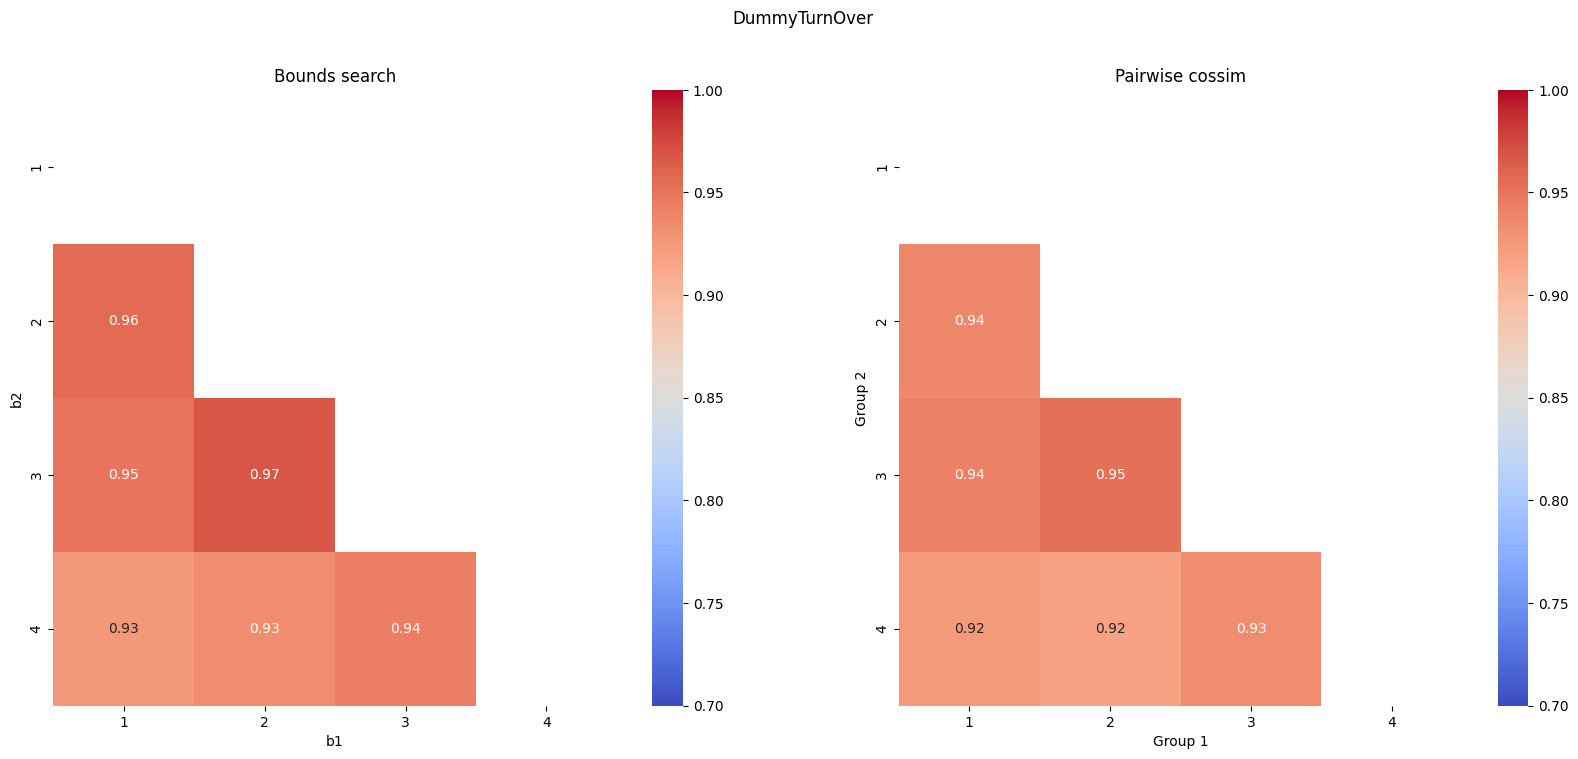

,b1,b2,mut_num1,mut_num2,cossim,ci2.5%,ci97.5%,enough_muts
0,1,4,1134,916,0.925505,0.885811,0.956399,True
3,2,4,2670,916,0.934175,0.899676,0.960792,True
5,3,4,4453,916,0.943209,0.913211,0.966501,True
1,1,3,1134,2699,0.950415,0.924495,0.969982,True
2,1,2,1134,4235,0.955796,0.930389,0.974445,True
4,2,3,2670,2699,0.968245,0.951522,0.980893,True


In [35]:
splitting_machine("DummyTurnOver", fp_table="../data/processed/DummyTurnOver_bounds.csv")

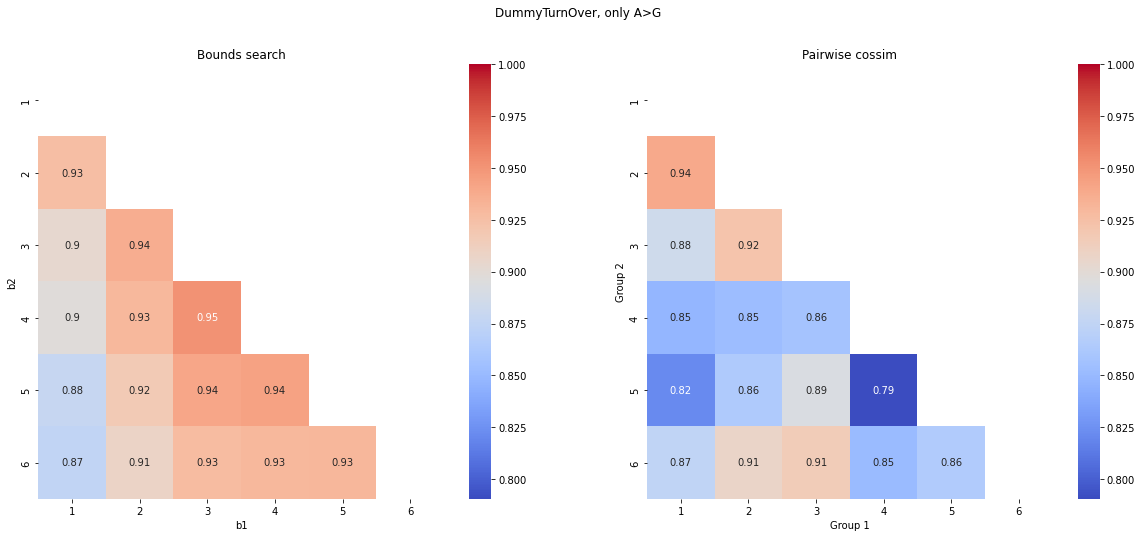

,b1,b2,mut_num1,mut_num2,cossim,ci2.5%,ci97.5%,enough_muts
0,1,6,1305,571,0.874979,0.755442,0.954564,True
1,1,5,1305,1065,0.878892,0.766922,0.951336,True
2,1,4,1305,1716,0.897647,0.814794,0.960698,True
3,1,3,1305,3499,0.902729,0.833212,0.959923,True
5,2,6,2841,571,0.907944,0.820729,0.961019,True
6,2,5,2841,1065,0.917292,0.838327,0.965558,True
4,1,2,1305,5035,0.926343,0.859763,0.971315,True
9,3,6,4624,571,0.927726,0.864140,0.968480,True
7,2,4,2841,1716,0.929752,0.867789,0.971503,True
12,4,6,5275,571,0.930311,0.852791,0.973309,True


In [198]:
splitting_machine("DummyTurnOver", sbs="A>G")

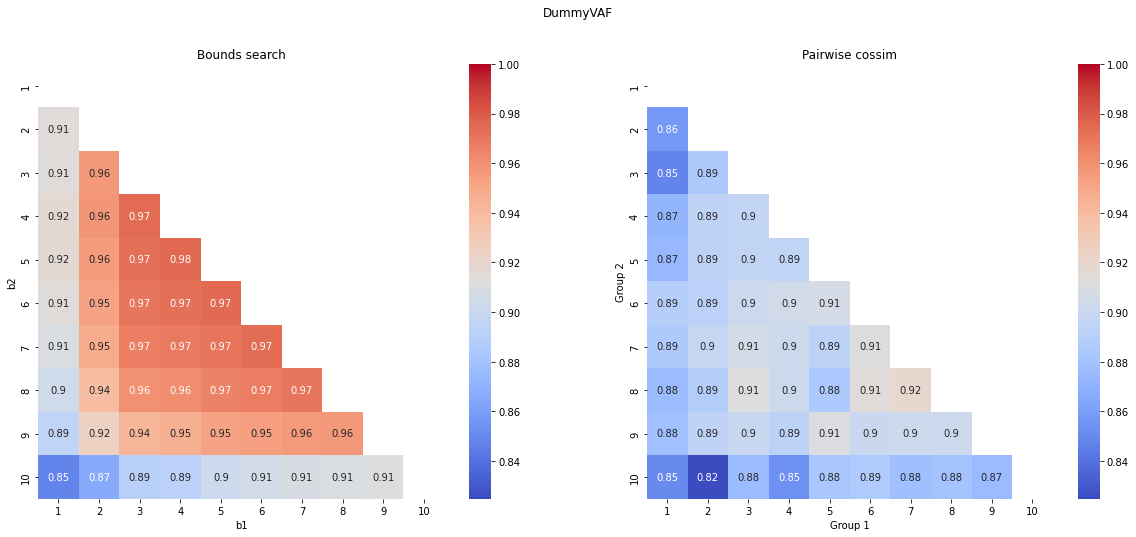

,b1,b2,mut_num1,mut_num2,cossim,ci2.5%,ci97.5%,enough_muts
0,1,10,571,557,0.847485,0.777814,0.902590,True
9,2,10,1203,557,0.865746,0.809868,0.913702,True
17,3,10,1856,557,0.890540,0.843548,0.926817,True
24,4,10,2502,557,0.892117,0.844592,0.929845,True
1,1,9,571,1170,0.894617,0.843881,0.937003,True


In [199]:
_ = splitting_machine("DummyVAF")
_.head()

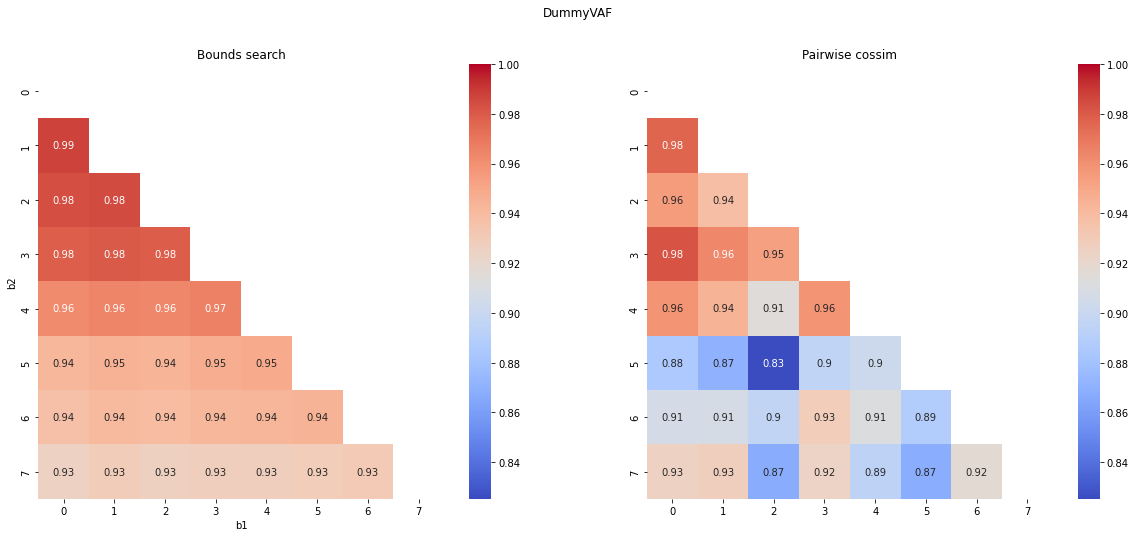

,b1,b2,mut_num1,mut_num2,cossim,enough_muts
0,0,7,3307,275,0.925480,True
13,2,7,4656,275,0.925871,True
18,3,7,5371,275,0.927499,True
22,4,7,5691,275,0.927556,True
25,5,7,5857,275,0.928735,True
7,1,7,4109,275,0.929298,True
27,6,7,6065,275,0.930890,True
1,0,6,3307,483,0.936551,True
14,2,6,4656,483,0.939545,True
8,1,6,4109,483,0.940324,True


In [38]:
# splitting_machine("DummyVAF")  # old

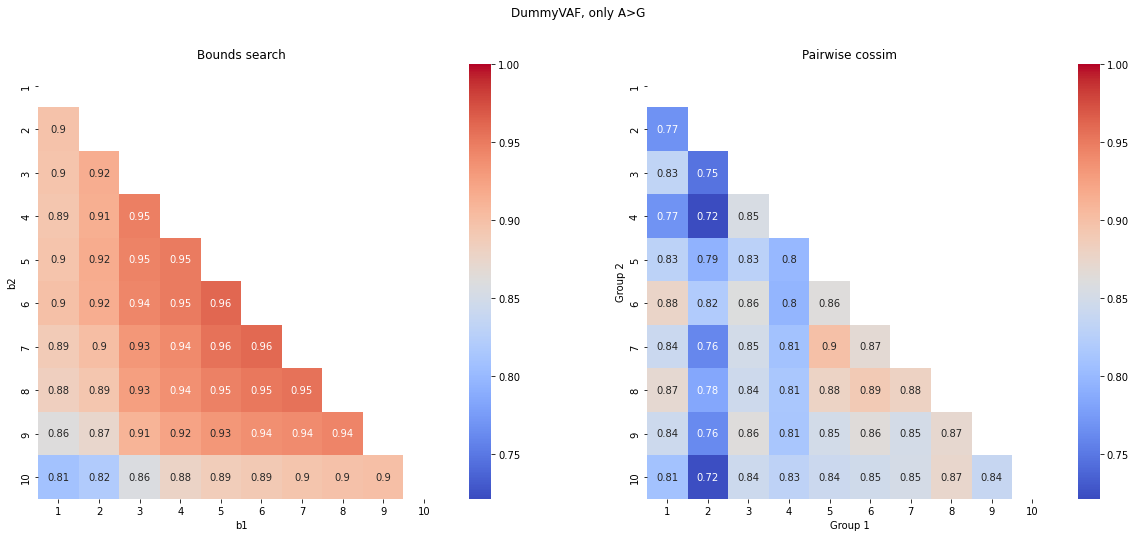

,b1,b2,mut_num1,mut_num2,cossim,ci2.5%,ci97.5%,enough_muts
0,1,10,571,557,0.809156,0.664366,0.908767,True
9,2,10,1203,557,0.819839,0.705671,0.904644,True
17,3,10,1856,557,0.857661,0.761947,0.926775,True
1,1,9,571,1170,0.861711,0.758119,0.938751,True
10,2,9,1203,1170,0.872879,0.783768,0.939371,True


In [200]:
_ = splitting_machine("DummyVAF", sbs="A>G")
_.head()

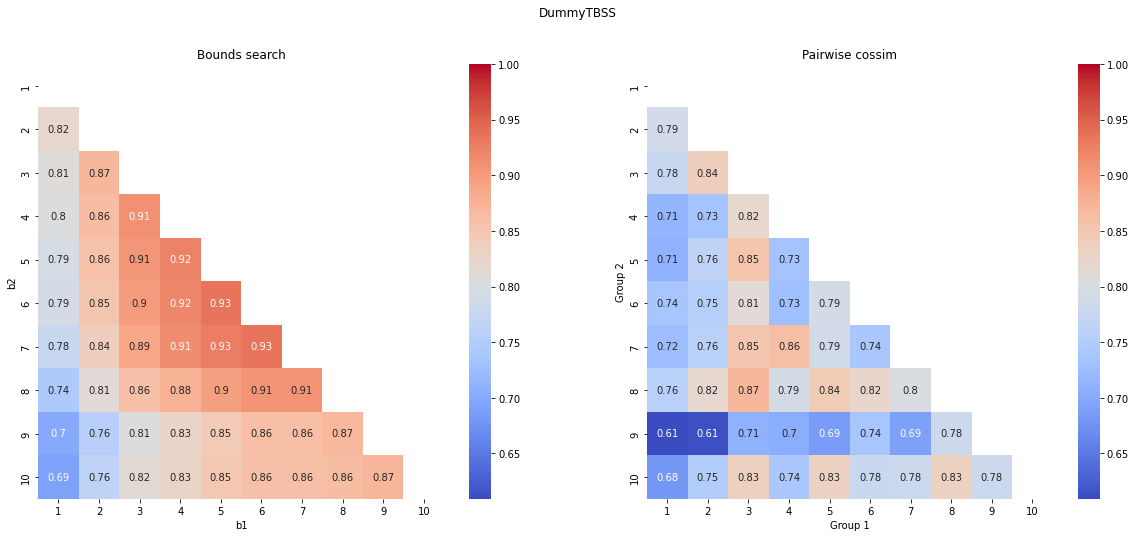

,b1,b2,mut_num1,mut_num2,cossim,ci2.5%,ci97.5%,enough_muts
0,1,10,632,607,0.690620,0.599726,0.773874,True
1,1,9,632,1249,0.699938,0.610283,0.782821,True
2,1,8,632,1869,0.744003,0.673570,0.817210,True
10,2,9,1271,1249,0.755633,0.684195,0.819660,True
9,2,10,1271,607,0.764484,0.683155,0.840193,True


In [201]:
_ = splitting_machine("DummyTBSS")
_.head()
# be carefull, mutspecs normalized on the same mutations excluding genome positioning, that is nessesary in case of TBSS

In [206]:
pair = splitting_machine3d("DummyTurnOver", "DummyVAF", fp_table="../data/processed/DummyTurnOver&DummyVAF_bounds.csv")
pair[pair.enough_muts].head(15)

,DummyTurnOver_b1,DummyTurnOver_b2,DummyVAF_b1,DummyVAF_b2,mut_num1,mut_num2,cossim,ci2.5%,ci97.5%,enough_muts
12,1,6,2,7,265,255,0.721757,0.598105,0.826609,True
56,1,5,2,8,265,335,0.723281,0.601842,0.822422,True
57,1,5,2,7,265,450,0.731411,0.609968,0.830604,True
13,1,6,2,6,265,312,0.738404,0.609269,0.834899,True
100,1,4,2,9,265,304,0.738891,0.618670,0.830630,True
58,1,5,2,6,265,560,0.751793,0.647768,0.843025,True
144,1,3,2,10,265,274,0.758249,0.653667,0.847562,True
101,1,4,2,8,265,476,0.760466,0.655627,0.847940,True
228,2,6,1,7,277,255,0.770633,0.650566,0.863757,True
360,2,3,1,10,277,274,0.772338,0.667788,0.857976,True


In [36]:
# dropped tissues
pair = splitting_machine3d("DummyTurnOver", "DummyVAF", bootstrap=False)

In [38]:
pair[pair.enough_muts].head(15)

,DummyTurnOver_b1,DummyTurnOver_b2,DummyVAF_b1,DummyVAF_b2,mut_num1,mut_num2,cossim,ci2.5%,ci97.5%,enough_muts
125,1,2,6,10,646,338,0.891047,None,None,True
147,2,4,2,7,512,309,0.897301,None,None,True
138,2,4,1,7,264,309,0.898558,None,None,True
129,1,2,7,10,758,338,0.899045,None,None,True
139,2,4,1,6,264,421,0.899691,None,None,True
181,2,3,1,9,264,416,0.901036,None,None,True
148,2,4,2,6,512,421,0.904574,None,None,True
63,1,3,3,9,348,416,0.905222,None,None,True
132,1,2,8,10,872,338,0.907258,None,None,True
114,1,2,4,10,430,338,0.910043,None,None,True


## Aggregate low and high values of TurnOver and VAF to single table

In [ ]:
# # # ???
# mutations["DummyTurnOver"] = 1                                                                        # Tiny
# mutations.loc[(mutations.TurnOverDays >= 35) & (mutations.TurnOverDays < 250), "DummyTurnOver"] = 2   # Small
# mutations.loc[(mutations.TurnOverDays > 250) & (mutations.TurnOverDays < 500), "DummyTurnOver"] = 3   # Medium
# mutations.loc[mutations.TurnOverDays == 1000, "DummyTurnOver"] = 4                                    # Large
# mutations.loc[(mutations.TurnOverDays > 4000) & (mutations.TurnOverDays < 6000), "DummyTurnOver"] = 5 # Huge
# mutations.loc[mutations.TurnOverDays > 8000, "DummyTurnOver"] = 6                                     # Eternal

In [19]:
mutations.TBSS.quantile(np.linspace(0.1, 1, 10))

0.1     3400.0
0.2     6795.0
0.3     8282.2
0.4     9822.6
0.5    11189.0
0.6    12541.0
0.7    13972.2
0.8    15454.0
0.9    17784.4
1.0    20450.0
Name: TBSS, dtype: float64

In [20]:
mutations.tumor_var_freq.quantile(np.linspace(0.1, 1, 10))

0.1     1.17
0.2     1.48
0.3     1.95
0.4     2.79
0.5     4.37
0.6     7.66
0.7    16.57
0.8    39.88
0.9    75.72
1.0    99.86
Name: tumor_var_freq, dtype: float64

In [11]:
MutExDloop["OutLongevity"] = None
MutExDloop["OutVAF"] = None
MutExDloop.loc[(MutExDloop.DummyTurnOver <= 1), "OutLongevity"] = "Low"
MutExDloop.loc[(MutExDloop.DummyTurnOver >= 3), "OutLongevity"] = "High"
MutExDloop.loc[(MutExDloop.DummyVAF <= 2), "OutVAF"] = "Low"
MutExDloop.loc[(MutExDloop.DummyVAF >= 9), "OutVAF"] = "High"

MutExDloop.groupby(["OutLongevity", "OutVAF"]).Mut.count()

OutLongevity  OutVAF
High          High      416
              Low       508
Low           High      262
              Low       241
Name: Mut, dtype: int64

In [18]:
data = []
for to1 in MutExDloop.OutLongevity.unique():
    if not isinstance(to1, str):
        continue
    for vaf1 in MutExDloop.OutVAF.unique():
        if not isinstance(vaf1, str):
            continue
        for to2 in MutExDloop.OutLongevity.unique():
            if not isinstance(to2, str):
                continue
            for vaf2 in MutExDloop.OutVAF.unique():
                if not isinstance(vaf2, str):
                    continue
                sim, confint = cossimExDloopSign(
                    MutExDloop[(MutExDloop.OutLongevity == to1) & (MutExDloop.OutVAF == vaf1)],
                    MutExDloop[(MutExDloop.OutLongevity == to2) & (MutExDloop.OutVAF == vaf2)],
                    threads=8,
                    niters=1,
                )
                one_data = {
                    "Longevity1": to1,
                    "VAF1": vaf1,
                    "Longevity2": to2,
                    "VAF2": vaf2,
                    "cossim": sim,
                    "ci2.5%": confint[0],
                    "ci97.5%": confint[1],
                }
                data.append(one_data)

In [19]:
df = pd.DataFrame(data).sort_values("Longevity1 VAF1 Longevity2 VAF2".split(), ascending=[False, False, False, False])
# df.to_csv("../data/processed/cossim_heatmap.csv", index=None)
sim_matrix = df.pivot(["Longevity1", "VAF1"], ["Longevity2", "VAF2"], "cossim")
sim_matrix

Longevity2            Low                High          
VAF2                  Low      High       Low      High
Longevity1 VAF1                                        
High       High  0.878846  0.904382  0.864232  1.000000
           Low   0.803852  0.869298  1.000000  0.864232
Low        High  0.892078  1.000000  0.869298  0.904382
           Low   1.000000  0.892078  0.803852  0.878846

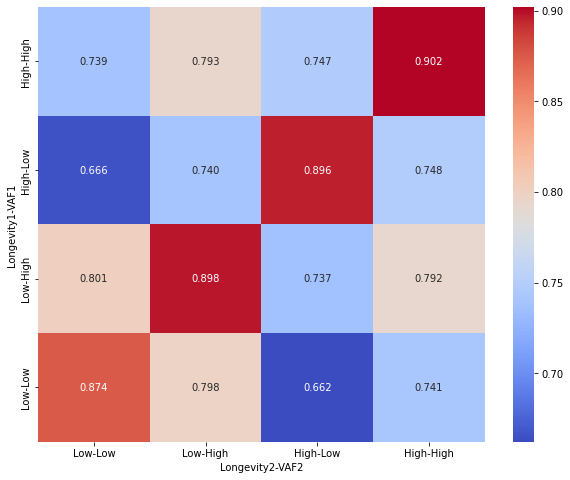

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(sim_matrix, annot=True, fmt=".3f", cmap="coolwarm")
plt.savefig("../figures/cossim_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

### Dendrogram

In [12]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

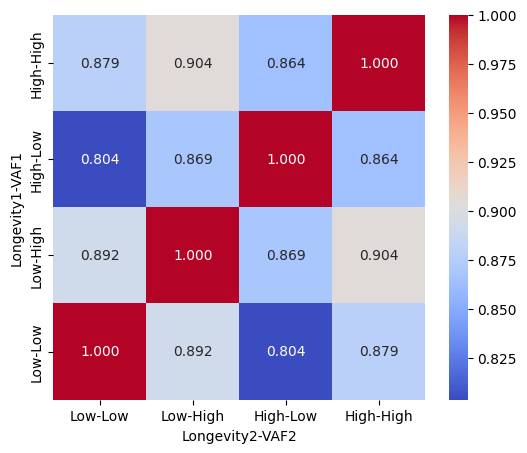

In [20]:
plt.figure(figsize=(6, 5))
sns.heatmap(sim_matrix, annot=True, fmt=".3f", cmap="coolwarm");

Text(0.5, 0, 'Cosine distance')

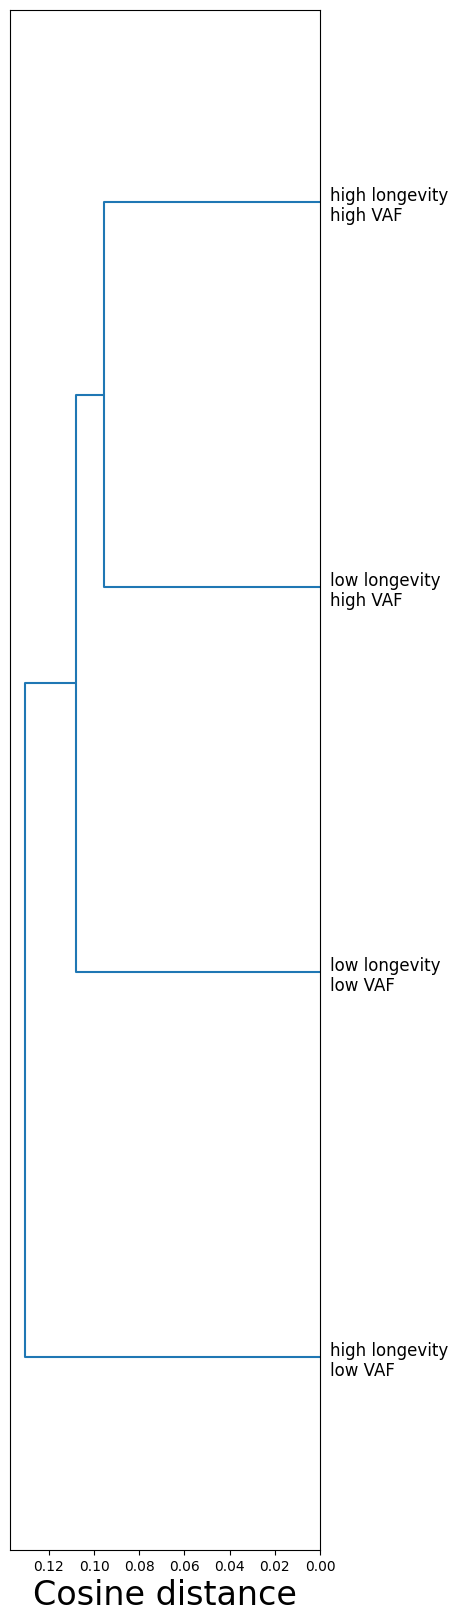

In [86]:
mat = 1 - sim_matrix[::-1].values
ytdist = squareform(mat)

Z = hierarchy.linkage(ytdist, 'single')

plt.figure(figsize=(4, 20))

dn = hierarchy.dendrogram(
    Z, orientation='left', 
    labels=["low longevity\nlow VAF", "low longevity\nhigh VAF", "high longevity\nlow VAF", "high longevity\nhigh VAF"],
    # no_labels=True,
)
plt.xlabel("Cosine distance", fontsize=24)
# plt.savefig("../figures/dendro.pdf", dpi=300, bbox_inches="tight")

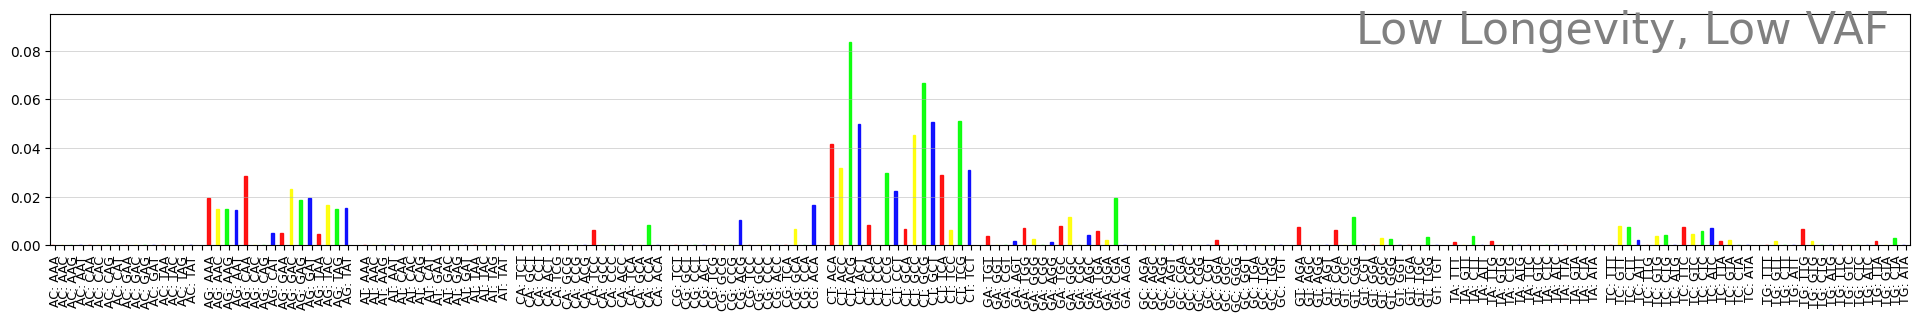

In [77]:
from mutspec_utils.draw.sbs_orders import ordered_sbs192_kk
from mutspec_utils.draw.spectra import _coloring192kk, __prepare_nice_labels


def plot_mutspec192kk(mutspec192: pd.DataFrame, ylabel="MutSpec", title="Mutational spectrum", show=True, figsize=(24, 6), filepath=None):
    ms192 = mutspec192.copy()
    ms192["long_lbl"] = ms192.Mut.str.get(2) + ms192.Mut.str.get(4) + ": " + ms192.Mut.str.get(0) + ms192.Mut.str.get(2) + ms192.Mut.str.get(-1)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.grid(axis="y", alpha=.7, linewidth=0.5)
    order = __prepare_nice_labels(ordered_sbs192_kk)
    sns.barplot(
        x="long_lbl", y=ylabel, data=ms192,
        order=order, 
        errwidth=1, ax=fig.gca(), 
    )

    plt.xticks(rotation=90, fontsize=9)
    # labels = ax.get_xticklabels()  # + ax.get_yticklabels()
    # [label.set_fontweight('bold') for label in labels]
    # ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("Mutational spectrum")
    ax.set_ylabel("")
    ax.set_yticks([0, 0.02, 0.04, 0.06, 0.08])
    ax.set_ylim(0, 0.095)
    ax.text(142, 0.083, title, fontsize=32, color="gray")
    # map colors to bars
    clrs_iterator = _coloring192kk()
    for bar, sbs in zip(ax.patches, order):
        if len(sbs):
            bar.set_color(next(clrs_iterator))
            bar.set_alpha(alpha=0.9)
        bar.set_width(0.3)
    if filepath is not None:
        plt.savefig(filepath, dpi=300, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close()


plot_mutspec192kk(ms, title=f"{to1} Longevity, {vaf1} VAF", figsize=(24, 3), )

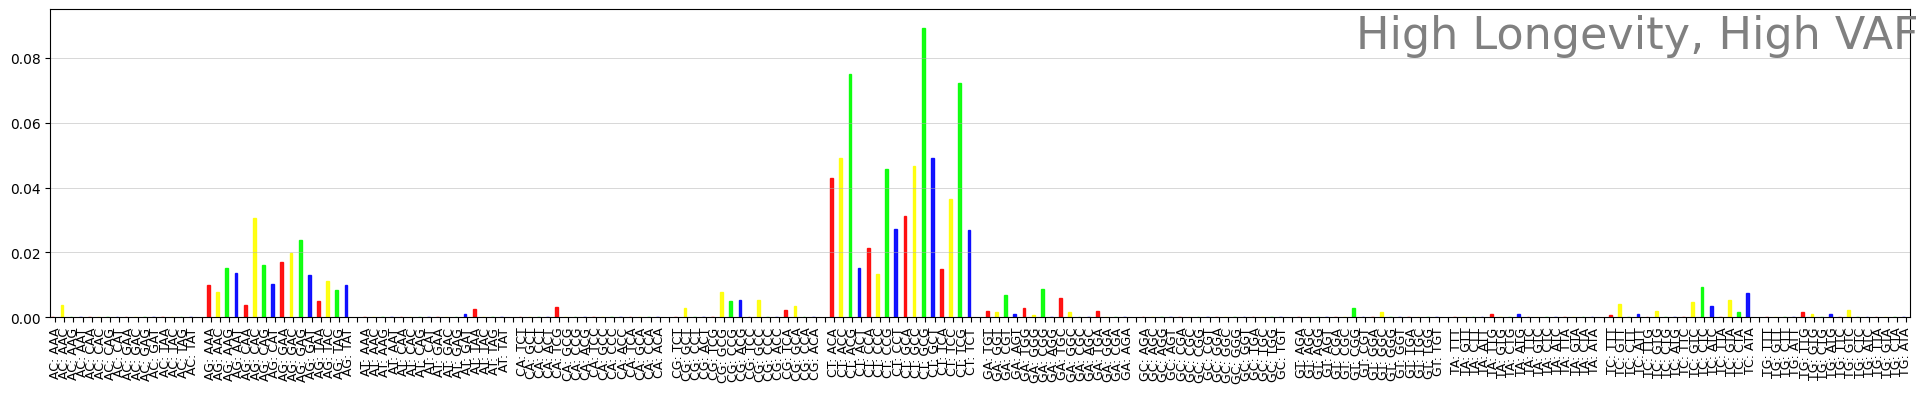

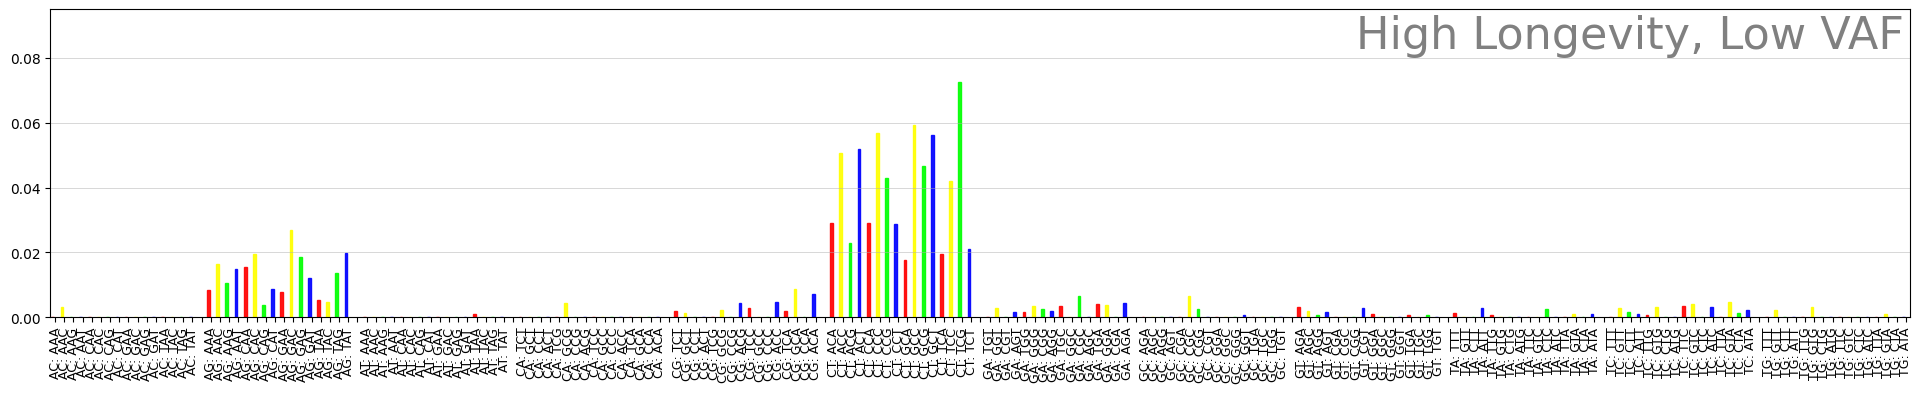

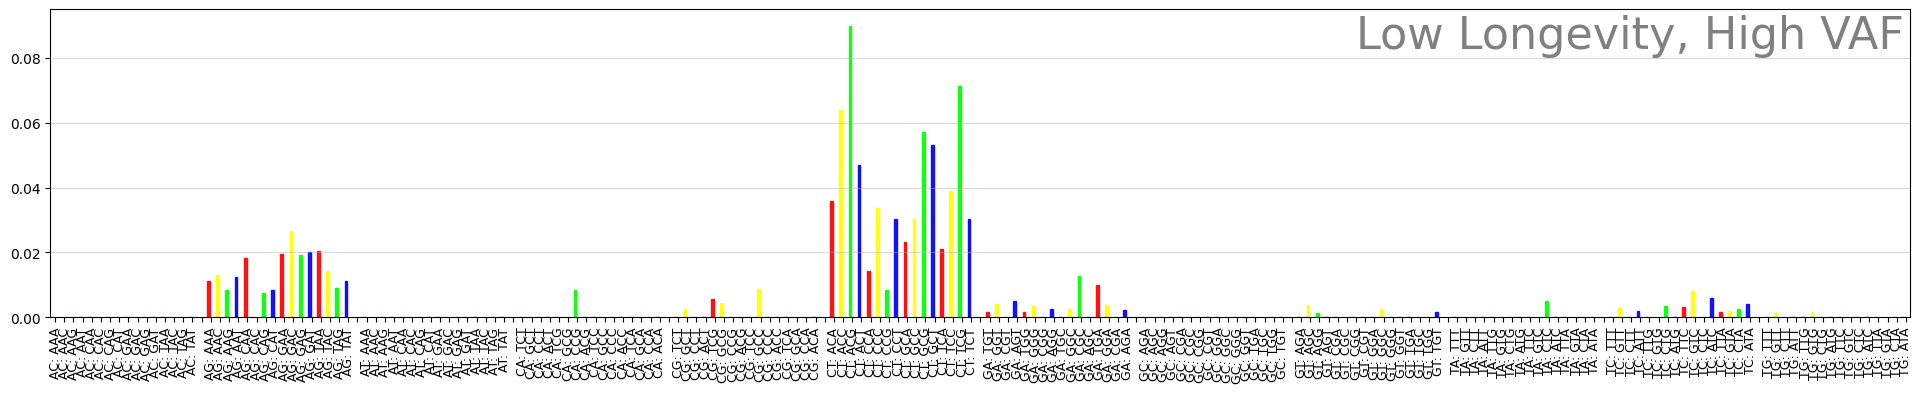

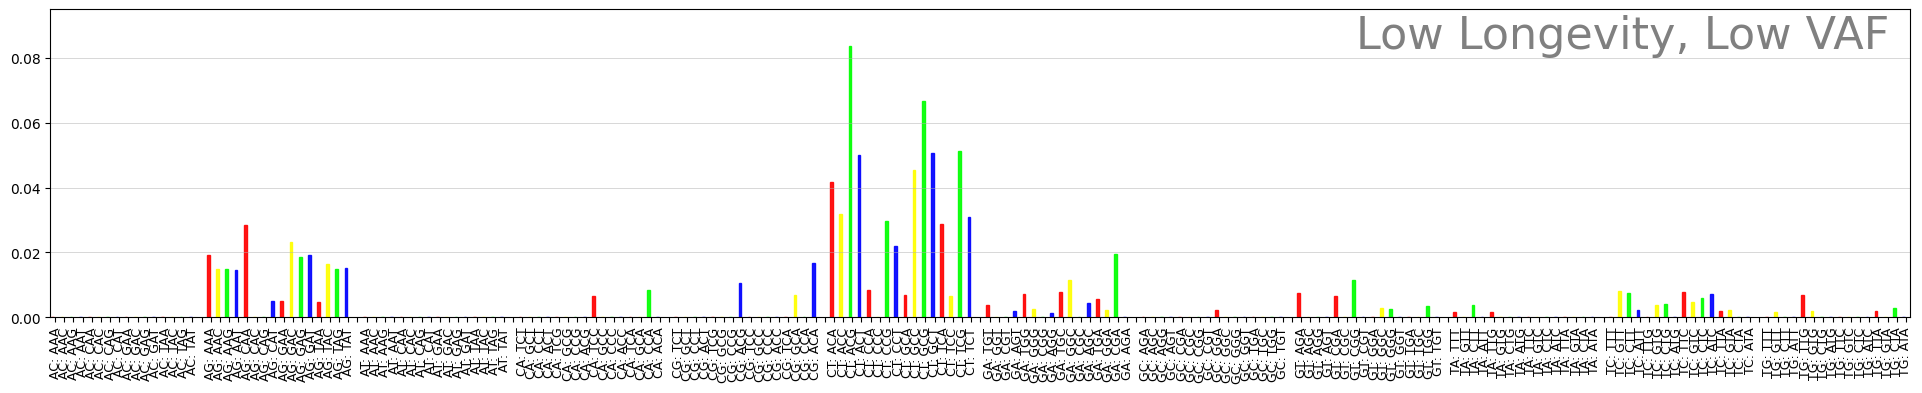

In [78]:
for to1 in MutExDloop.OutLongevity.unique():
    if not isinstance(to1, str):
        continue
    for vaf1 in MutExDloop.OutVAF.unique():
        if not isinstance(vaf1, str):
            continue
        mut_sample = MutExDloop[(MutExDloop.OutLongevity == to1) & (MutExDloop.OutVAF == vaf1)]
        ms = calculate_mutspec(mut_sample, exp_muts192["ExDloop"], use_context=True)
        ms["Mut"] = ms["Mut"].apply(rev_comp)
        plot_mutspec192kk(ms, title=f"{to1} Longevity, {vaf1} VAF", figsize=(24, 4), filepath=f"../figures/ms192_Longevity-{to1}_VAF-{vaf1}.pdf")

In [43]:
def sample_mutations(mutations: pd.DataFrame, method="bootstrap"):
    """bootstrap or permutations"""
    if method == "bootstrap":
        mutations = mutations.sample(mutations.shape[0], replace=True)
    elif method == "permutations":
        raise NotImplementedError()
    else:
        raise ValueError("Pass appropriate method: 'bootstrap'")
    return mutations
    

def compare_signuficantly(mutations: pd.DataFrame, feature: str, b1, b2, sbs=None, niters=5000, method="bootstrap", mode="one-tailed"):
    """
    бутстрепнутые выборки более случайны, а значит более непохожие, поэтому можно брать one-tailed, 
    ведь обратное маловероятно
    """
    cossims = []
    mut1 = mutations[(mutations[feature] <= b1)]
    mut2 = mutations[(mutations[feature] >= b2)]
    true_csim = cossimExDloop(mut1, mut2, sbs)

    for _ in range(niters):
        mut_sample = sample_mutations(mutations, method=method)
        mut1 = mut_sample[(mut_sample[feature] <= b1)]
        mut2 = mut_sample[(mut_sample[feature] >= b2)]
        csim = cossimExDloop(mut1, mut2, sbs)
        cossims.append(csim)

    cossims = np.array(cossims)
    p1 = (cossims > true_csim).sum() / niters
    if mode == "two-tailed":
        p2 = (cossims < (cossims.mean() * 2 - true_csim)).sum() / niters
    elif mode == "one-tailed":
        p2 = 0
    pvalue = p1 + p2
    return true_csim, pvalue, cossims


def compare_signuficantly_2fea(mutations: pd.DataFrame, feature1, feature2, f1b1, f1b2, f2b1, f2b2, sbs=None, niters=5000, method="bootstrap", mode="one-tailed"):
    cossims = []
    mut1 = mutations[
        (mutations[feature1] <= f1b1) &
        (mutations[feature2] <= f2b1)
    ]
    mut2 = mutations[
        (mutations[feature1] >= f1b2) &
        (mutations[feature2] >= f2b2)
    ]
    true_csim = cossimExDloop(mut1, mut2, sbs)

    for _ in range(niters):
        mut_sample = sample_mutations(mutations, method=method)
        mut1 = mut_sample[
            (mut_sample[feature1] <= f1b1) &
            (mut_sample[feature2] <= f2b1)
        ]
        mut2 = mut_sample[
            (mut_sample[feature1] >= f1b2) &
            (mut_sample[feature2] >= f2b2)
        ]
        csim = cossimExDloop(mut1, mut2, sbs)
        cossims.append(csim)

    cossims = np.array(cossims)
    p1 = (cossims > true_csim).sum() / niters
    if mode == "two-tailed":
        p2 = (cossims < (cossims.mean() * 2 - true_csim)).sum() / niters
    elif mode == "one-tailed":
        p2 = 0
    pvalue = p1 + p2
    return true_csim, pvalue, cossims

In [44]:
true_csim, pvalue, cossims = compare_signuficantly(MutExDloop, "DummyTurnOver", 0, 5, niters=3000)
true_csim, pvalue

(0.9369251196869489, 0.019333333333333334)

In [45]:
true_csim, pvalue, cossims = compare_signuficantly(MutExDloop, "DummyTurnOver", 0, 4, niters=5000)
true_csim, pvalue

(0.9525835280472803, 0.0262)

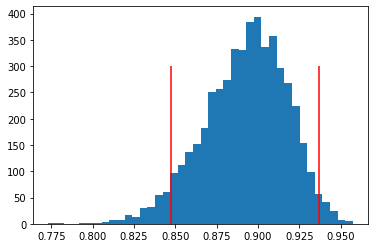

In [123]:
plt.hist(cossims, bins=40)
plt.vlines([true_csim, cossims.mean() * 2 - true_csim], 0, 300, 'r')

In [46]:
true_csim, pvalue, cossims = compare_signuficantly(MutExDloop, "DummyVAF", 0, 7, niters=2000)
true_csim, pvalue

(0.9254796182674041, 0.009)

In [47]:
true_csim, pvalue, cossims = compare_signuficantly(MutExDloop, "DummyVAF", 2, 7, niters=2000)
true_csim, pvalue

(0.9258713069328847, 0.0115)

In [48]:
true_csim, pvalue, cossims = compare_signuficantly_2fea(MutExDloop, "DummyVAF", "DummyTurnOver", 1, 4, 0, 3, niters=2000)
true_csim, pvalue

(0.8633848623330866, 0.035)

In [49]:
true_csim, pvalue, cossims = compare_signuficantly_2fea(MutExDloop, "DummyVAF", "DummyTurnOver", 0, 4, 0, 3, niters=2000)
true_csim, pvalue

(0.8547415188326101, 0.0485)

## Plan

1. (done) VAF & TurnOver trashholds machine
2. (done) Compare only A>G 
3. (done) pvalue
4. context for TBSS (optional)

aaaaaaaaaa

1. add pval to all
2. (done) use deciles
